In [39]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd

In [40]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [53]:
torch.manual_seed(0)
np.random.seed(0)

ratio_train = 0.8

input_data = torch.from_numpy(np.load("input.npy")).type(torch.float32)
output_data = torch.from_numpy(np.load("output.npy")).type(torch.float32).unsqueeze(-1)

n_train = int(np.round(len(input_data) * ratio_train))

input_function_train = input_data[:n_train, :]
output_function_train = output_data[:n_train, :]
input_function_test = input_data[n_train:, :]
output_function_test = output_data[n_train:, :]

batch_size = 16

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

print(input_function_train.shape)
print(output_function_train.shape)
print(output_function_train.shape)

torch.Size([26, 100, 100, 3])
torch.Size([26, 100, 100, 1])
torch.Size([26, 100, 100, 1])


In [54]:
learning_rate = 0.001

# epochs = 250
epochs = 10
step_size = 50
gamma = 0.5

fno_architecture = {
    "modes": 16,
    "width": 64,
    "n_layers": 2,
    "retrain_fno": 1
}

fno = FNO2d(fno_architecture)

In [55]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.002297269951668568  ######### Relative L2 Test Norm: 481785.25
######### Epoch: 1  ######### Train Loss: 0.001162378874141723  ######### Relative L2 Test Norm: 470604.40625
######### Epoch: 2  ######### Train Loss: 0.0004943038948113099  ######### Relative L2 Test Norm: 112222.109375
######### Epoch: 3  ######### Train Loss: 0.00016507105283380952  ######### Relative L2 Test Norm: 365112.125
######### Epoch: 4  ######### Train Loss: 0.0004896478640148416  ######### Relative L2 Test Norm: 297903.625
######### Epoch: 5  ######### Train Loss: 0.0002346829787711613  ######### Relative L2 Test Norm: 83886.3828125
######### Epoch: 6  ######### Train Loss: 1.9430426164035453e-05  ######### Relative L2 Test Norm: 141691.71875
######### Epoch: 7  ######### Train Loss: 0.00010984609980368987  ######### Relative L2 Test Norm: 216772.5625
######### Epoch: 8  ######### Train Loss: 0.0001595832291059196  ######### Relative L2 Test Norm: 153524.09375
######

torch.Size([1, 100, 100, 3])
torch.Size([1, 100, 100, 1])


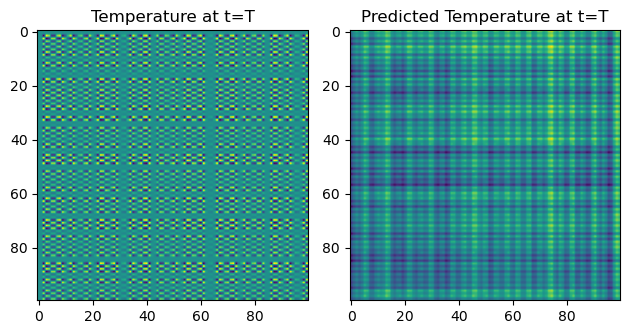

In [74]:
idx_data = 0
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n).detach().numpy()

fig, axes = plt.subplots(1, 2)  # Create a figure with two subplots

# Plot the first image on the left subplot
axes[0].imshow(output_function_test_n[0])
axes[0].set_title('Temperature at t=T')

# Plot the second image on the right subplot
axes[1].imshow(output_function_test_pred_n[0])
axes[1].set_title('Predicted Temperature at t=T')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()  # Display the plot

In [78]:
input_function_test_n[0][:,:,0]

tensor([[-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219],
        [-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219],
        [-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219],
        ...,
        [-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219],
        [-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219],
        [-1.0000,  0.0000,  0.5000,  ...,  0.0781,  0.5781, -0.4219]])